# Домашнее задание №4. Дедлайн - 21 ноября
Основы машинного обучения. А.Шестаков  
Группа ML-13. __Студент - Усцов Артем Алексеевич__

Правила:

* Отчеты принимаются до 23:59 21 ноября. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит, что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


# Part 0. Service function declaration

Connecting all the libraries necessary for work and declaring functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

%matplotlib inline

# Part 1. Задача про датчики на руках
В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [3]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [4]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,...,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,...,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,...,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,...,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,...,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,...,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [5]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

<AxesSubplot:xlabel='time'>

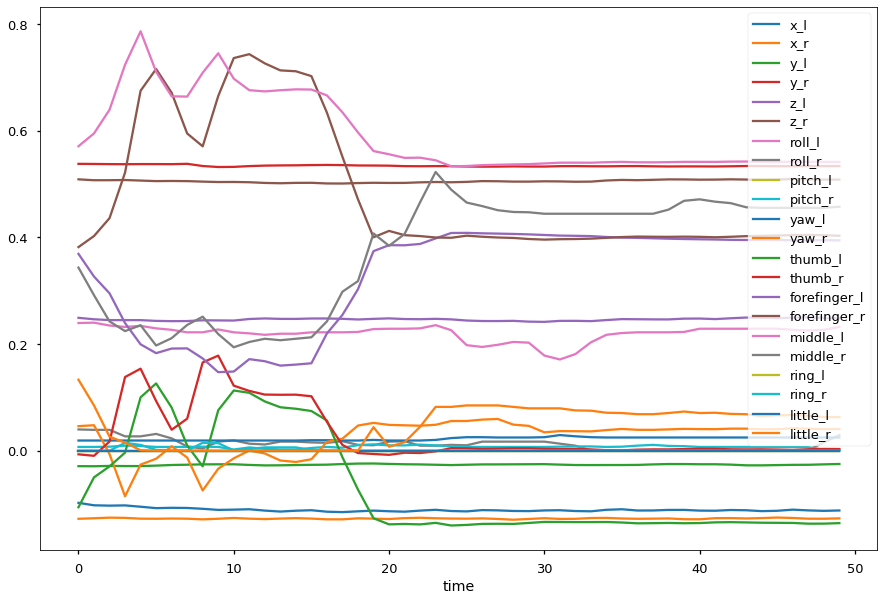

In [6]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Part 1. 1 Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [9]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

mkdir: невозможно создать каталог «./data»: Файл существует
--2021-11-20 20:57:08--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Распознаётся www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6026:18::a27d:4612
Подключение к www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 301 Moved Permanently
Адрес: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [переход]
--2021-11-20 20:57:09--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа... 302 Found
Адрес: https://uc0b98ced883903d0070afd4407f.dl.dropboxusercontent.com/cd/0/inline/BaVQxs0WnEXWWYOImmUAMQtnkuCAht4vL0I9V2CKRPUVFgJiYKgPVgfhOQj6s7HjNzhiOaASUJ51Mx9rPLARaAvuqsPccuGHxYw4YcDQNi16yBl1kEFmx03uFvdHmv0YpfDEOr1HKN4oYHFt4XiDmXgE/file# [переход]
--2021-11-20 20:57:09--  https://uc0b98ced883903d0070afd44

In [10]:
sign_features_filtered.shape

(2565, 11517)

In [11]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,...,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_standard_deviation__r_0.45,little_l__symmetry_looking__r_0.05,y_l__symmetry_looking__r_0.35000000000000003
0,0,0.014764,0.998626,0.000174,0.047854,0.000034,0.006166,0.000423,0.000015,0.003881,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.017579,0.017579,0.000180,0.045183,0.000027,0.003599,0.000397,0.000012,0.003399,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.043917,0.043917,0.000737,0.059952,0.000092,0.028252,0.001034,0.000142,0.011921,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0.061037,0.061037,0.001453,0.402618,0.000127,0.047034,0.001777,0.000314,0.017728,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Part 1.2 Базовая модель

В результате у нас получилось очень много признаков __(11517)__, давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [13]:
sign_classes["class"].values

array(['alive', 'alive', 'alive', ..., 'zero', 'zero', 'zero'],
      dtype=object)

In [14]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes["class"].values

In [15]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [16]:
base_cv_scores.mean()

0.9196881091617932

## Part 1.3 Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

Создадим бейзлайн c уменьшением размерности при помощи метода главных компонент.
Основанием для его использования будет являться наличие большого количества признаков.

#### (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений

In [98]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10, random_state=42, svd_solver='randomized')),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [99]:
# Достигнутое качество
base_cv_scores.mean()

0.7056530214424951

#### (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 

Заведем функцию зависимости качества модели от количества компонент

In [89]:
def find_min_num_of_components(X, y, required_model_score):
    num_of_components = 1
    base_score = 0.0
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    while (base_score < required_model_score):
        num_of_components += 1
        base_model = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=num_of_components, random_state=42, svd_solver='randomized')),
            ('clf', KNeighborsClassifier(n_neighbors=9))
        ])
        base_score = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy').mean()

    return num_of_components

In [90]:
# It takes about 7 minutes to calculate
# You can uncomment this and make sure of the authenticity by yourself.

# num_of_components = find_min_num_of_components(X, y, 0.9)

In [78]:
# Расчетное минимальное количество компонент
num_of_components

62

In [ ]:
# Neccesary hardcoding to avoid the waiting
num_of_components = 62

In [79]:
# Будем делать кросс-валидацию на 5 фолдов
# Дополнительно произведем нормализацию данных при помощи StandardScaler()

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=num_of_components, random_state=42, svd_solver='randomized')),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [81]:
# Достигнутое качество
base_cv_scores.mean()

0.901364522417154

In [82]:
# Лучшая модель
base_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 PCA(n_components=62, random_state=42,
                     svd_solver='randomized')),
                ('clf', KNeighborsClassifier(n_neighbors=9))])

#### (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

In [97]:
print(f"Объясненная доля дисперсии данных при минимальном количестве компонент:\
      {round(np.cumsum(pipeline[1].explained_variance_ratio_)[-1] * 100, 3)}%")

Объясненная доля дисперсии данных при минимальном количестве компонент:      58.27%


# Part 2. Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [100]:
df = pd.read_csv('./data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [101]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Внутренняя политика: культура                    100
Проишествия  РФ                                  100
Спорт                                            100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

In [411]:
print(f"Количество реальных кластеров в данных: {len(df.loc[:, 'class'].unique())}")

Количество реальных кластеров в данных: 11


Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубриками с помощью ARI

## Part 3.1 Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [102]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [103]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [104]:
import nltk

In [105]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

In [106]:
!pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz

Defaulting to user installation because normal site-packages is not writeable
--2021-11-20 22:07:01--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Распознаётся download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.245, 5.45.205.242, 5.45.205.241, ...
Подключение к download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.245|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 302 Found
Адрес: https://ext-cachev2-mskbeeline05.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=1525 [переход]
--2021-11-20 22:07:01--  https://ext-cachev2-mskbeeline05.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=1525
Распознаётся ext-cachev2-mskbeeline05.cdn.yandex.net (ext-cachev2-mskbeeline05.cdn.yandex.net)... 128.75.242.190, 2a00:1248:5001:4::223
Подключение к ext-cachev2-mskbeeline05.cdn.yandex.net (ext-cachev2-mskbeeline05.cdn.yandex.net)|128.75.242.190|:443... соединение уста

In [132]:
%%time 
from pymystem3 import Mystem


# Нормилизуем текст при помощи лемматизации
bin_path = "./mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

df.text = df.text.apply(lemmatize)

CPU times: user 2.71 s, sys: 185 ms, total: 2.89 s
Wall time: 21.3 s


In [108]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Удалим стоп-слова
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [131]:
# Первая статья после предобработки
df.text[0]

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор никола

In [164]:
df

,text,date,event,class
0,петербург проходить митинг против передача иса...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,москва январь ситуация передача исаакиевский с...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,аргумент факт москва январь оппозиция провожат...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,новость топ москва январь акция против передач...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,газета москва январь московский патриархия про...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
...,...,...,...,...
1925,москва сентябрь кандидат депутат москва покуса...,2017-09-10,Единый день голосования,Внутренняя политика РФ
1926,москва сентябрь избирком оценивать явка выборы...,2017-09-10,Единый день голосования,Внутренняя политика РФ
1927,москва сентябрь кандидат столичный депутат пож...,2017-09-10,Единый день голосования,Внутренняя политика РФ
1928,москва сентябрь медведев припоминать избранный...,2017-09-10,Единый день голосования,Внутренняя политика РФ


## Part 3.2 Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [110]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [307]:
texts = df.text.values
texts

array(['петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собор

In [119]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    data_tfidf = tfidf_vectorizer.fit_transform(data)

    return data_tfidf, tfidf_vectorizer

In [133]:
# Возвращает значения - важности каждого документа внутри всего корпуса
texts_tfidf, tfidf_vectorizer = tfidf(texts)
texts_tfidf.data

array([0.05150022, 0.05912033, 0.03235832, ..., 0.11870986, 0.07506706,
       0.02825582])

In [180]:
texts_tfidf.shape

(1930, 22466)

In [423]:
from sklearn.metrics import pairwise_distances
S = pairwise_distances(texts_tfidf)
S

array([[0.        , 0.93774548, 0.88372209, ..., 1.37425102, 1.37222408,
        1.37885284],
       [0.93774548, 0.        , 0.98481386, ..., 1.40558051, 1.39055207,
        1.3982028 ],
       [0.88372209, 0.98481386, 0.        , ..., 1.36151458, 1.37868392,
        1.36022237],
       ...,
       [1.37425102, 1.40558051, 1.36151458, ..., 0.        , 1.21917646,
        1.27335143],
       [1.37222408, 1.39055207, 1.37868392, ..., 1.21917646, 0.        ,
        1.28048111],
       [1.37885284, 1.3982028 , 1.36022237, ..., 1.27335143, 1.28048111,
        0.        ]])

[[Text(0.5, 0, ''),
  Text(57.5, 0, ''),
  Text(114.5, 0, ''),
  Text(171.5, 0, ''),
  Text(228.5, 0, ''),
  Text(285.5, 0, ''),
  Text(342.5, 0, ''),
  Text(399.5, 0, ''),
  Text(456.5, 0, ''),
  Text(513.5, 0, ''),
  Text(570.5, 0, ''),
  Text(627.5, 0, ''),
  Text(684.5, 0, ''),
  Text(741.5, 0, ''),
  Text(798.5, 0, ''),
  Text(855.5, 0, ''),
  Text(912.5, 0, ''),
  Text(969.5, 0, ''),
  Text(1026.5, 0, ''),
  Text(1083.5, 0, ''),
  Text(1140.5, 0, ''),
  Text(1197.5, 0, ''),
  Text(1254.5, 0, ''),
  Text(1311.5, 0, ''),
  Text(1368.5, 0, ''),
  Text(1425.5, 0, ''),
  Text(1482.5, 0, ''),
  Text(1539.5, 0, ''),
  Text(1596.5, 0, ''),
  Text(1653.5, 0, ''),
  Text(1710.5, 0, ''),
  Text(1767.5, 0, ''),
  Text(1824.5, 0, ''),
  Text(1881.5, 0, '')],
 [Text(0, 0.5, ''),
  Text(0, 48.5, ''),
  Text(0, 96.5, ''),
  Text(0, 144.5, ''),
  Text(0, 192.5, ''),
  Text(0, 240.5, ''),
  Text(0, 288.5, ''),
  Text(0, 336.5, ''),
  Text(0, 384.5, ''),
  Text(0, 432.5, ''),
  Text(0, 480.5, ''),


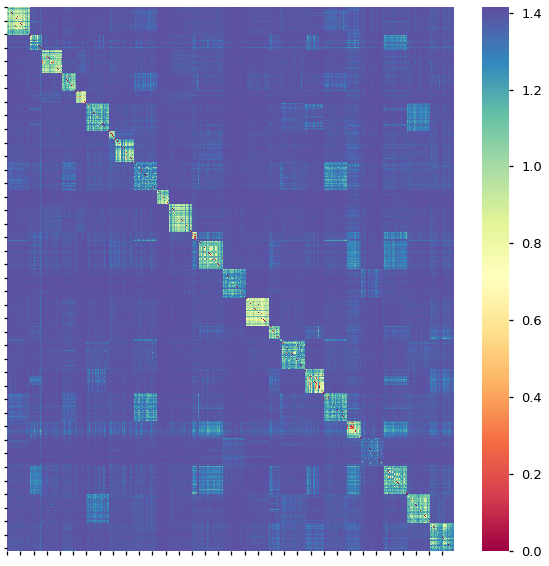

In [130]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль __главной__ диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## Part 3.2 DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [136]:
from sklearn.neighbors import NearestNeighbors

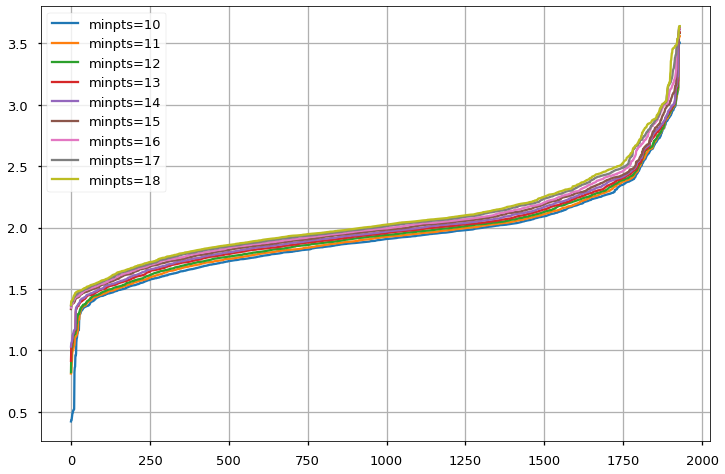

In [1215]:
fig, ax = plt.subplots()

for i in range(10, 19):
    nn = NearestNeighbors(n_neighbors=i)
    nn.fit(S)
    dist, _ = nn.kneighbors()
    dist_last = dist[:,-1]
    dist_last = np.sort(dist_last)
    plt.plot(dist_last, label='minpts=' + str(i))
# ax.vlines(x, y_min, y_max)
plt.legend()
plt.grid()

In [1248]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.25, 
                min_samples=19).fit(S)
labels = dbscan.labels_

# Объекты с индексом -1 - есть индексы "выбросных" кластеров
print(np.unique(labels))
print(f"Количество получившихся кластеров в данных: {len(np.unique(labels))}")
print(f"Количество реальных кластеров в данных: {len(df.loc[:, 'class'].unique())}\n")

print(pd.Series(labels).value_counts())
pd.crosstab(df.loc[:, 'class'], labels)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Количество получившихся кластеров в данных: 20
Количество реальных кластеров в данных: 11

 11    205
 5     194
 7     178
 10    170
-1     163
 18    100
 0     100
 14     99
 12     97
 9      96
 2      83
 15     79
 6      72
 3      64
 8      49
 16     45
 4      41
 13     38
 1      37
 17     20
dtype: int64


col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
class,,,,,,,,,,,,,,,,,,,,
Важные мировые события,24,0,37,83,0,41,0,0,0,0,0,80,1,0,38,0,79,0,20,0
Внутренняя политика РФ,20,100,0,0,2,0,0,0,0,0,0,0,1,97,0,0,0,45,0,99
Внутренняя политика РФ: оппозиция,36,0,0,0,62,0,0,0,178,0,0,0,1,0,0,0,0,0,0,0
Внутренняя политика: культура,4,0,0,0,0,0,0,0,0,0,96,0,0,0,0,0,0,0,0,0
Международные отношения,63,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,10,0,0,0,0,0,0,72,0,0,0,0,0,0,0,0,0,0,0,0
Проишествия РФ,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,99,0,0,0,0
Спорт,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0
Спорт,0,0,0,0,0,0,0,0,0,0,0,0,101,0,0,0,0,0,0,1


In [1249]:
# # Удалим "выбросный" класс
# actual_labels = np.delete(labels, np.where(labels == -1))

In [1250]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df["class"])
true_labels = encoder.transform(df["class"])
np.unique(true_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1251]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
adjusted_rand_score(true_labels, labels)

0.47107313724858035

__Как итог, будем считать, что кластеризация получилась неудачной__
1) С учетом подбора minpts и epsilon вменяемый показатель ARI получается на 19 точках, однако при этом количество кластеров равняется 20, что противоречит фактическим 11  
2) Согласно ARI успешно кластеризовать получилось только 47% пар признаков, что будем считать неудовлетворительным показателем

Требуется углубление знаний в использовании DBSCAN и улучшение качества модели